In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [191]:
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
def fit_test(pipe, X, y, train_px, valid_px, blind_set=True, unblind=False, overlap_ok=False):
    
    if len(train_px.intersection(valid_px)) and not overlap_ok: raise RuntimeError("Patient index leak")
    
    pipe.fit(X.loc[train_px], y.loc[train_px])
        
    try:
        df_coef = pd.DataFrame([pipe.named_steps['clf'].coef_[0], np.sign(pipe.named_steps['clf'].coef_[0])], columns=X.columns, index=['coef', 'sign'])
    except:
        df_coef = pd.DataFrame()
        
    valid_scores = pipe.predict_proba(X.loc[valid_px])[:,1]
    valid_labels = y.loc[valid_px].values
    
    # If it's a blind set and no unblinding, shuffle
    if blind_set and not unblind:
        np.random.shuffle(valid_scores)
        
    return valid_scores, valid_labels, df_coef
    
import matplotlib.pyplot as plt



def generate_auc_plot(labels, scores, title='Receiver operating characteristic', merge=True, average=True, figsize=(6,6), max_folds=10, names=None, extra_opts=None):
    """ Makes the nice fold-wise, average, and merged AUROC plots
    labels: a list of label arrays
    scores: a list of score arrays
    title: A title for the plot
    figsize: Figure size
    merge: Whether to merge the list of labels, scores in CV fashion (e.g. set to false for subsampling)
    max_folds: Maximum number of folds to show
    """
    if extra_opts is None: extra_opts = {}
        
    plt.figure(figsize=figsize)
    tprs = []
    aucs = []
    
    l_v_scores =[]
    l_v_labels = []

    mean_fpr = np.linspace(0, 1, 100)

    for i, (fold_labels, fold_scores) in enumerate(zip(labels, scores)):
        fpr, tpr, thresholds = roc_curve(fold_labels, fold_scores)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        
        if names is not None:
            label = '%s (AUC = %0.2f)' % (names[i], roc_auc)
            opts = {'alpha':1.0, 'lw':1}
            opts.update(extra_opts.get(names[i], {}))
        else:
            label = 'Fold %d (AUC = %0.2f)' % (i + 1, roc_auc)
            opts = {'alpha':0.5, 'lw':1}
            alpha = 0.5
            
        if max_folds is None or i < max_folds: 
            plt.plot(fpr, tpr, label=label, **opts)
        print ('Fold %d (AUC = %0.2f), N=%d' % (i + 1, roc_auc, len(fold_labels)))
        
        if merge:
            l_v_scores.extend(fold_scores)
            l_v_labels.extend(fold_labels)

    if merge:
        fpr, tpr, thresholds = roc_curve(l_v_labels, l_v_scores)
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, color='k', label='Merged ROC (AUC = %0.2f)' % (roc_auc))

    if average: 
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
# 10 fold CV results on training set

In [192]:
df = pd.read_parquet('march.parquet').drop_duplicates(subset=['bar_time', 'ticker']).set_index(['ticker', 'bar_time'])
df

open_price  high_price  low_price  close_price  \
ticker bar_time                                                              
MULN   2022-03-01 13:00:00       1.850       1.850       1.85         1.85   
AREB   2022-03-01 13:00:00       1.660       1.660       1.63         1.63   
BTBT   2022-03-01 13:00:00       4.120       4.120       4.12         4.12   
ZVZZT  2022-03-01 13:00:00      10.015      10.015      10.01        10.01   
CTIC   2022-03-01 13:00:00       3.030       3.100       3.03         3.09   
...                                ...         ...        ...          ...   
SOXS   2022-03-03 21:54:00       4.450       4.450       4.45         4.45   
GGB    2022-03-03 21:55:00       5.620       5.620       5.62         5.62   
       2022-03-03 21:56:00       5.620       5.620       5.62         5.62   
DBD    2022-03-03 21:57:00       7.560       7.560       7.56         7.56   
GPS    2022-03-03 21:59:00      15.640      15.640      15.64        15.64   

                            volume         first_seen_time  
ticker bar_time                                             
MULN   2022-03-01 13:00:00   727.0 2022-03-01 13:01:00.022  
AREB   2022-03-01 13:00:00   745.0 2022-03-01 13:01:00.066  
BTBT   2022-03-01 13:00:00   100.0 2022-03-01 13:01:00.022  
ZVZZT  2022-03-01 13:00:00  2000.0 2022-03-01 13:01:00.018  
CTIC   2022-03-01 13:00:00  2500.0 2022-03-01 13:01:00.019  
...                            ...                     ...  
SOXS   2022-03-03 21:54:00  5000.0 2022-03-03 21:55:00.661  
GGB    2022-03-03 21:55:00   223.0 2022-03-03 21:56:00.650  
       2022-03-03 21:56:00  1500.0 2022-03-03 21:57:00.557  
DBD    2022-03-03 21:57:00   400.0 2022-03-03 21:58:00.752  
GPS    2022-03-03 21:59:00   100.0 2022-03-03 22:00:00.608  

[1626392 rows x 6 columns]

In [236]:
class DaysTrading:
    def __init__(self, df, year, month, day):
        self.t_start = pd.Timestamp(datetime(year, month, day))
        self.t_end   = pd.Timestamp(datetime(year, month, day + 1))
        
        self.buy_time   = pd.Timestamp(datetime(year, month, day, 14, 35, 0))
        self.stop_time  = pd.Timestamp(datetime(year, month, day, 14, 40, 0))
        self.premarket_time  = pd.Timestamp(datetime(year, month, day, 14, 30, 0))
                               
        self.data = get_slice_by_time(df, self.t_end, self.t_start)
        
    def get_slice_by_time(self, df, t1, t0=None):
        df = df.loc[df.index.get_level_values('bar_time') < t1]
        if t0 is not None: df = df.loc[df.index.get_level_values('bar_time') >= t0]
        return df
    
    def get(self): return self.data.copy()
                               
dt_0 = DaysTrading(df, 2022, 3, 1)

In [237]:
def labelize(dt):    
    """ Returns high values reached greater than 2.5% the open price of the next tick """
    df = dt.get()
        
    after_prediction_open = df.loc[df.first_seen_time > dt.buy_time, 'open_price'] # We buy at the first tick after T_buy
    after_prediction_high = df.loc[df.first_seen_time > dt.buy_time, 'high_price'] # We buy at the first tick after T_buy
    
    first_bar = after_prediction_open.groupby('ticker').first()
    
    return after_prediction_high.div(first_bar, level='ticker', axis='index').groupby('ticker').max().ge(1.025)
    
        
y = labelize(dt_0)

In [238]:
def fx_gate_performance(dt):
    """ Returns first 5 mins """
    df = dt.get()
    
    after_premarket_open = df.loc[df.first_seen_time >= dt.premarket_time, 'open_price']
    before_buy_high      = df.loc[df.first_seen_time <  dt.buy_time, 'high_price']
    
    first_bar = after_premarket_open.groupby('ticker').first()
    
    ticker_group = before_buy_high.div(first_bar, level='ticker', axis='index').groupby('ticker')
    
    out = ticker_group.agg({'mean', 'count', 'max', 'min', 'std', 'skew'})
    
    return out

X1 = fx_gate_performance(dt_0)

In [239]:
def fx_premarket_activity(dt):
    """ Returns online tickes in premarket """
    df = dt.get()
    
    premarket_volume = df.loc[df.first_seen_time < dt.premarket_time, 'volume'] # We buy at the first tick after T_buy
    
    counts = premarket_volume.groupby('ticker').count().rename('count_value')
    
    counts_present = counts.ge(0).rename('count>0')
    
    return pd.concat((counts, counts_present), axis=1)
    
X2 = fx_premarket_activity(dt_0)

In [240]:
X_aligned = X1.join(X2, how='outer')
y_aligned = y.reindex(X_aligned.index).fillna(0).astype(float)

In [241]:
data = X_aligned.join(y_aligned.rename('label'))
data

,mean,skew,min,count,std,max,count_value,count>0,label
ticker,,,,,,,,,
A,1.002018,NaN,1.000000,2,0.002854,1.004036,NaN,NaN,0.0
AA,1.023126,0.167584,1.019992,4,0.002673,1.026421,NaN,NaN,1.0
AAC,1.000000,NaN,1.000000,2,0.000000,1.000000,NaN,NaN,0.0
AAL,1.001253,-0.426677,0.995578,4,0.004670,1.005896,NaN,NaN,0.0
AAON,1.000000,NaN,1.000000,1,NaN,1.000000,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...
ZWS,1.000000,NaN,1.000000,1,NaN,1.000000,NaN,NaN,0.0
ZXIET,1.000000,NaN,1.000000,1,NaN,1.000000,NaN,NaN,0.0
ZY,1.000000,NaN,1.000000,1,NaN,1.000000,NaN,NaN,0.0


n_tickers =  2861
Making plot...
Fold 1 (AUC = 0.66), N=287
Fold 2 (AUC = 0.69), N=286
Fold 3 (AUC = 0.71), N=286
Fold 4 (AUC = 0.54), N=286
Fold 5 (AUC = 0.68), N=286
Fold 6 (AUC = 0.68), N=286
Fold 7 (AUC = 0.59), N=286
Fold 8 (AUC = 0.70), N=286
Fold 9 (AUC = 0.68), N=286
Fold 10 (AUC = 0.78), N=286
count>0        0.000000
skew           0.269773
count_value    0.312317
min            0.601514
count          1.217367
mean           1.594875
max            3.186969
std            3.507562
dtype: float64


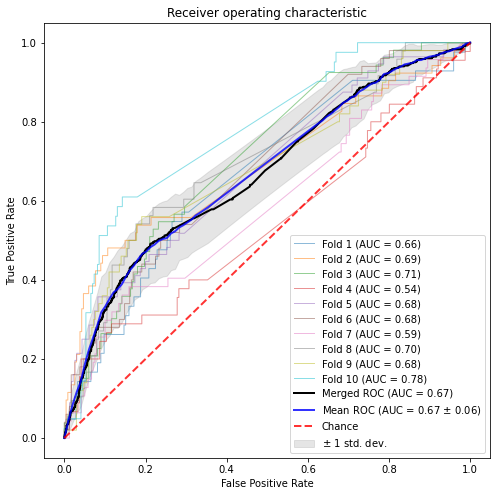

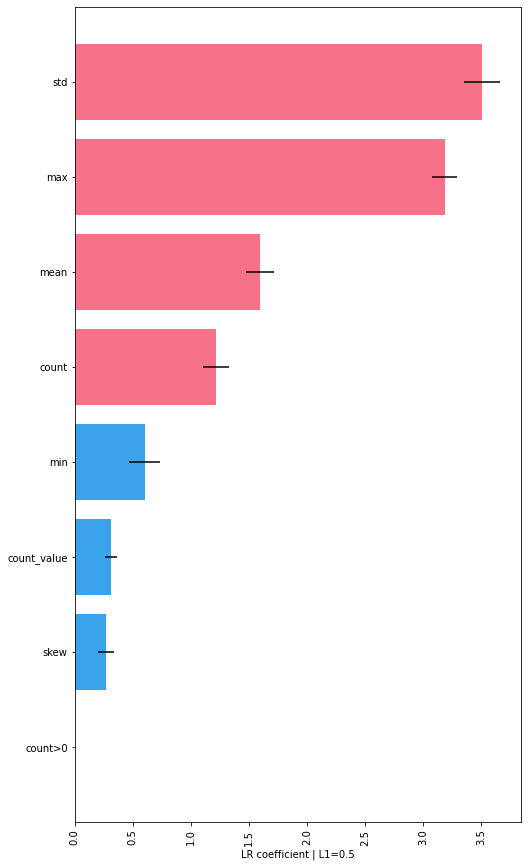

In [242]:


kf = KFold(n_splits=10, random_state=0, shuffle=True)

l_fold_scores = []
l_fold_labels = []

print ("n_tickers = ", len(data.index))
    
df_coef_cln = pd.DataFrame()
for fold, (train, test) in enumerate(list(kf.split(data.index))):

    train_px = data.index[train]
    valid_px = data.index[test]
    
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('imputer', SimpleImputer()), 
        ('clf', LogisticRegression(penalty='elasticnet', max_iter=500, solver='saga', l1_ratio=0.1, C=1, class_weight='balanced'))
    ])
        
    check_scores, check_labels, df_coef = fit_test(pipe, data.drop(columns=['label']), data['label'], train_px, valid_px, blind_set=False)
    
    df_coef_cln = pd.concat([df_coef_cln, df_coef])
    
    l_fold_scores.append(check_scores)
    l_fold_labels.append(check_labels)

        
print ("Making plot...")
generate_auc_plot(l_fold_labels, l_fold_scores, max_folds=10, figsize=(8,8))
try:
    fx_importance = df_coef_cln.loc['coef'].T.mean(axis=1).abs().sort_values(ascending=True)
    fx_error = 2*df_coef_cln.loc['coef'].T.loc[fx_importance.index].sem(axis=1)
    fx_sign = -np.sign(df_coef_cln.loc['coef'].T.loc[fx_importance.index].mean(axis=1))
    print (fx_importance)
        
    plt.figure(figsize=(8,15))
    plt.barh(fx_importance.index, fx_importance, xerr=fx_error, color = [sns.color_palette("husl", 3)[int(i)] for i in fx_sign.values + 1])
    plt.xlabel("LR coefficient | L1=0.5")
    ticks = plt.xticks(rotation=90)
    plt.xlim(0)
except Exception as err: print (err)

plt.savefig('coef.pdf', bbox_inches='tight')

In [164]:
X = X.reindex(y.index)

In [ ]:
pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('imputer', SimpleImputer()), 
        ('clf', LogisticRegression(penalty='elasticnet', max_iter=500, solver='saga', l1_ratio=0.5, C=1, class_weight='balanced'))
    ])

In [8]:
df = pd.read_csv('all.csv').drop_duplicates(subset=['bar_time', 'ticker']).set_index('bar_time').drop(columns='Unnamed: 0')
df

,ticker,open_price,high_price,low_price,close_price,volume
bar_time,,,,,,
2022-02-25 18:57:00,IMPP,1.460,1.460,1.460,1.460,400.0
2022-02-25 18:57:00,PHUN,2.880,2.880,2.880,2.880,100.0
2022-02-25 18:57:00,WISH,2.180,2.180,2.180,2.180,100.0
2022-02-25 18:57:00,SENS,1.820,1.820,1.820,1.820,100.0
2022-02-25 18:58:00,UUU,3.930,3.930,3.930,3.930,200.0
...,...,...,...,...,...,...
2022-02-26 00:02:00,ZBH,125.810,125.810,125.810,125.810,125.0
2022-02-26 00:02:00,PLTR,11.365,11.380,11.365,11.375,800.0
2022-02-26 00:02:00,CVE,15.095,15.095,15.095,15.095,329.0


<AxesSubplot:xlabel='bar_time'>

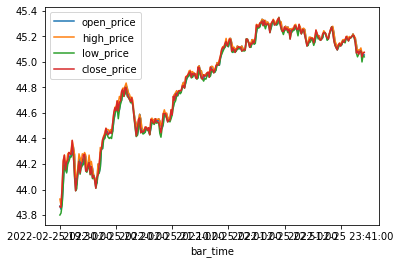

In [10]:
df.loc[df.ticker=='BAC', ~df.columns.str.contains('volume')].plot()

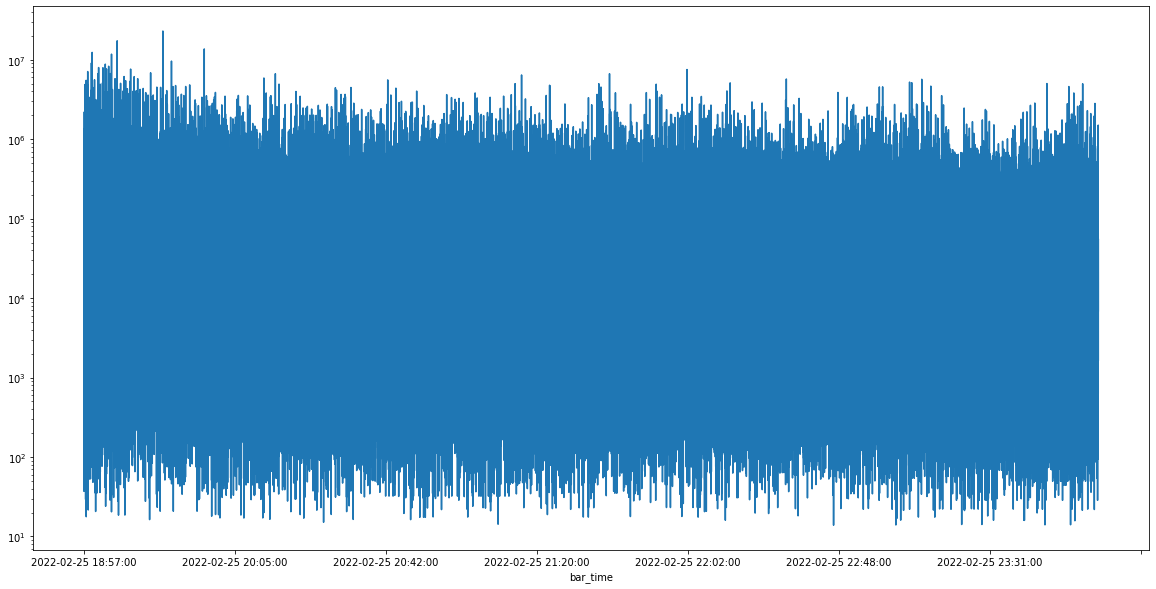

In [20]:
plt.figure(figsize=(20, 10))
(df.loc[:, 'close_price'] * df.loc[:, 'volume']).plot()
plt.yscale('log')

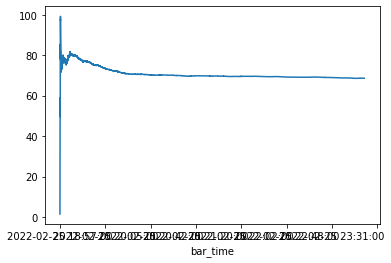

In [59]:
fig, ax= plt.subplots()

(np.cumsum(df.volume*(df.high_price+df.low_price)/2) / np.cumsum(df.volume)).plot()

plt.show()